# Numerical Solution of the Two-Dimensional Helmholtz Equation using the Finite Element Method

This notebook illustrates the numerical solution of the two-dimensional wave equation for harmonic excitation using the [Finite Element Method](https://en.wikipedia.org/wiki/Finite_element_method) (FEM).

## Problem Statement

The inhomogeneous linear wave equation is given as

\begin{equation}
\Delta p(\mathbf{x}, t) - \frac{1}{c^2} \frac{d^2}{\partial t^2} p(\mathbf{x}, t) = q(\mathbf{x}, t)
\end{equation}

where $p(\mathbf{x}, t)$ denotes the sound pressure at position $\mathbf{x}$, $c$ the speed of sound and $q(\mathbf{x}, t)$ the inhomogeneity. For an harmonic excitation $q(\mathbf{x}, t) = \Re \{ Q(\mathbf{x}, \omega) e^{j \omega t} \}$ with frequency $\omega = 2 \pi f$ we chose the Ansatz $p(\mathbf{x}, t) = \Re \{ P(\mathbf{x}, \omega) e^{j \omega t} \}$ for the sound pressure. Introduction of the complex quantities into the wave equation yields

\begin{equation}
\Delta P(\mathbf{x}, \omega) e^{j \omega t} + \frac{\omega^2}{c^2} P(\mathbf{x}, \omega) e^{j \omega t} = Q(\mathbf{x}, \omega) e^{j \omega t}
\end{equation}

canceling out the $e^{j \omega t}$ terms yields the [Helmholtz equation](https://en.wikipedia.org/wiki/Helmholtz_equation)

\begin{equation}
\Delta P(\mathbf{x}, \omega) + \frac{\omega^2}{c^2} P(\mathbf{x}, \omega) = Q(\mathbf{x}, \omega)
\end{equation}

We aim for a numerical solution of the Helmholtz equation on the domain $V$ with respect to homogeneous Dirichlet boundary conditions

\begin{equation}
P(\mathbf{x}, \omega) = 0 \qquad \text{for } x \in \partial V 
\end{equation}

or homogeneous Neumann boundary conditions

\begin{equation}
\frac{\partial}{\partial n} P(\mathbf{x}, \omega) = 0 \qquad \text{for } x \in \partial V 
\end{equation}

where $\partial V $ denotes the boundary of $V$.

## Variational Formulation

The FEM is based on expressing the partial differential equation (PDE) to be solved in its [variational](https://en.wikipedia.org/wiki/Calculus_of_variations) or weak form. The first step towards this formulation is to multiply the Helmholtz equation by the test function $V(\mathbf{x}, \omega)$

\begin{equation}
(\Delta P(\mathbf{x}, \omega)) V(\mathbf{x}, \omega)  + \frac{\omega^2}{c^2} P(\mathbf{x}, \omega) V(\mathbf{x}, \omega) = Q(\mathbf{x}, \omega) V(\mathbf{x}, \omega)
\end{equation}

followed by integration over the domain $V$

\begin{equation}
\int_V (\Delta P(\mathbf{x}, \omega)) V(\mathbf{x}, \omega) dx  + \frac{\omega^2}{c^2} \int_V P(\mathbf{x}, \omega) V(\mathbf{x}, \omega) dx = \int_V Q(\mathbf{x}, \omega) V(\mathbf{x}, \omega) dx
\end{equation}

where $dx$ denotes a suitably chosen differential element for integration. Application of [Green's first identity](https://en.wikipedia.org/wiki/Green%27s_identities) yields

\begin{equation}
- \int_V \nabla P(\mathbf{x}, \omega) \cdot \nabla V(\mathbf{x}, \omega) dx  + 
\int_{\partial V} \frac{\partial}{\partial n}  V(\mathbf{x}, \omega) ds
+ \frac{\omega^2}{c^2} \int_V P(\mathbf{x}, \omega) V(\mathbf{x}, \omega) dx = 
\int_V Q(\mathbf{x}, \omega) V(\mathbf{x}, \omega) dx
\end{equation}

This way the differential order of the first integral is lowered which is advisable for application of the FEM. The second integral vanishes as the variation formulation requires $V(\mathbf{x}, \omega) = 0$ on $\partial V$ where $P(\mathbf{x}, \omega)$ is known by for instance fixed boundary conditions. This results in the variational/weak formulation of the Helmholtz equation

\begin{equation}
- \int_V \nabla P(\mathbf{x}, \omega) \cdot \nabla V(\mathbf{x}, \omega) dx  
+ \frac{\omega^2}{c^2} \int_V P(\mathbf{x}, \omega) V(\mathbf{x}, \omega) dx = 
\int_V Q(\mathbf{x}, \omega) V(\mathbf{x}, \omega) dx
\end{equation}

It is common to express this in terms of the bilinear $a(P, V)$ and linear $L(V)$ forms 

\begin{equation}
a(P, V) = \frac{\omega^2}{c^2} \int_V P(\mathbf{x}, \omega) V(\mathbf{x}, \omega) dx - \int_V \nabla P(\mathbf{x}, \omega) \cdot \nabla V(\mathbf{x}, \omega) dx
\end{equation}

\begin{equation}
L(V) = \int_V Q(\mathbf{x}, \omega) V(\mathbf{x}, \omega) dx
\end{equation}

where

\begin{equation}
a(P, V) = L(V)
\end{equation}

## Numerical Solution

The numerical solution of the variational problem is based on [FEniCS](https://fenicsproject.org/), an open-source framework for numerical solution of PDEs. Its high-level Python interface `dolfin` is used in the following to define the problem and computing the solution. The implementation is based on the variational formulation derived above. It is common in the FEM to denote the solution of the problem by $u$ and the test function by $v$. The definition of the problem in FEniCS is very close to the mathematical formulation of the problem. We limit ourselves to real-valued $P(\mathbf{x}, \omega)$ due to the assumption of Dirichlet or Neumann boundary conditions.

For the subsequent examples the solution of inhomogeneous wave equation for a point source $Q(\mathbf{x}) = \delta(\mathbf{x}-\mathbf{x_s})$ at position $\mathbf{x_s}$ is computed using the FEM. A function is defined for this purpose, as well as for the plotting of the resulting sound field.

In [1]:
from dolfin import *
import mshr
import matplotlib.pyplot as plt
%matplotlib inline


def Helmholz_2D(mesh, frequency, xs, neumann_bc=True, c=343):
    '''Numerical solution of the two-dimensional Helmholtz equation 
       using the FEM'''
    
    # squared wavenumber
    k2 = (Constant(2*pi*frequency)/Constant(c))**2
    
    # define function space
    V = FunctionSpace(mesh, "CG", 1)

    # define boundary conditions
    if neumann_bc:
        bcs = None
    else:
        bcs = DirichletBC(V, Constant((0.,0.)), "on_boundary")
    
    # define variational problem
    u = TrialFunction(V)
    v = TestFunction(V)

    a = k2 * inner(u, v) * dx - inner(nabla_grad(u), nabla_grad(v)) * dx
    L = Constant(0.0) * v * dx
    
    A, b = assemble_system(a, L, bcs)
    
    # define inhomogenity
    delta = PointSource(V, xs, 1)
    delta.apply(b)

    # compute solution
    u = Function(V)
    solve(A, u.vector(), b)

    return u


def plot_soundfield(u):
    '''plots solution of FEM-based simulation'''
    fig = plt.figure(figsize=(10,10))
    fig = plot(u)
    plt.title(r'$P(\mathbf{x}, \omega)$')
    plt.xlabel(r'$x$ in m')
    plt.ylabel(r'$y$ in m')
    plt.colorbar(fig, fraction=0.038, pad=0.04);

### Sound Field in a Rectangular Room with Sound-Hard Boundaries

The two-dimensional sound field in a rectangular room (rectangular plate) with sound-hard boundaries (Neumann boundary conditions) is computed for the frequency $f=1000$ Hz and source position $x_s = (1.2,3.2)$ m.

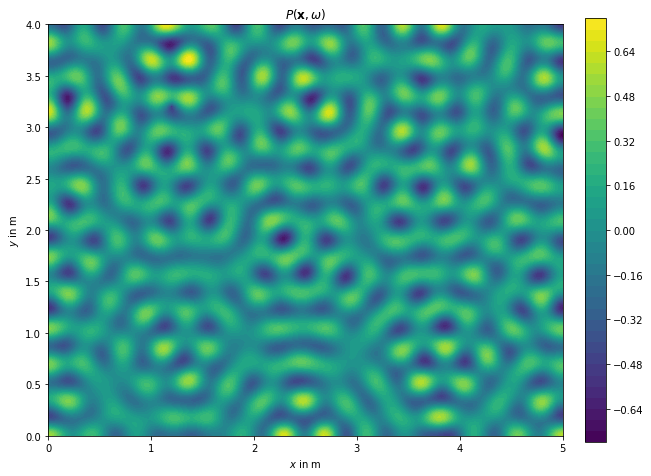

In [2]:
# define geometry and mesh
mesh = RectangleMesh(Point(0, 0), Point(5, 4), 200, 200, "right/left")

# compute solution
u = Helmholz_2D(mesh, 1000, Point(1.2, 3.2))

# plot sound field
plot_soundfield(u)

### Sound Field in Two Coupled Rectangular Rooms

The two-dimensional sound field in two coupled rectangular rooms with sound-hard boundaries (Neumann boundary conditions) is computed for the frequency $f=1000$ Hz and source position $x_s = (2,0.5)$ m. First the geometry is defined and plotted

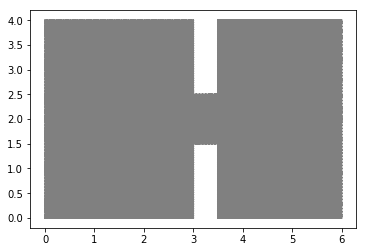

In [3]:
# define geometry and mesh
domain = mshr.Rectangle(Point(0, 0), Point(3,4)) + mshr.Rectangle(Point(3, 1.5), Point(3.5, 2.5)) + mshr.Rectangle(Point(3.5, 0), Point(6, 4))
mesh2 = mshr.generate_mesh(domain, 100)

plot(mesh2);

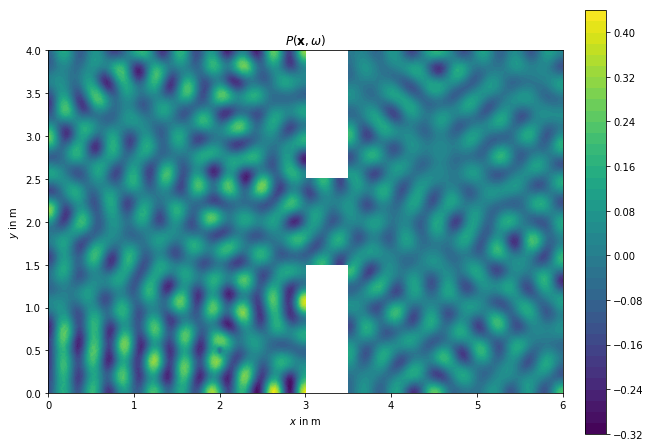

In [4]:
# compute solution
u = Helmholz_2D(mesh2, 1000, Point(2, .5))

# plot sound field
plot_soundfield(u)

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).